In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import proj3d
import itertools
import sys
sys.path.insert(0,'/usr/local/lib/python3.5/dist-packages/')
from joblib import Parallel, delayed
import math
from scipy import linalg as splin
import copy
import pickle

In [2]:
"""
Plotting Functions
"""

def plot3D(px,py,pz,clist,emphPoints = [],cmap='plasma',shadow=False,useCMAP = True,xLabel='',yLabel='',zLabel='',savefig='',saveN = 1):
    
    elev = 30
    azim = 60

    viewVect = [np.cos(np.pi*180/elev)*np.sin(np.pi*180/azim),np.cos(np.pi*180/elev)*np.cos(np.pi*180/azim),np.cos(np.pi*180/elev)]
    
    thetalist = np.linspace(0,2*np.pi,saveN + 1)
    thetalist = thetalist[:-1]
    
    projMat = np.array([px,py])
    
    for idx in range(saveN):
        theta = thetalist[idx]
        rotMat = np.array([[np.cos(theta),-np.sin(theta)],[np.sin(theta),np.cos(theta)]])
        
        rotx,roty = np.dot(rotMat,projMat)
        rotz = pz
        clistRot = clist
        
        p = np.array([rotx,roty,rotz])
        dots = np.array(np.dot(viewVect,p))
        sort = dots.argsort()

        fig = plt.figure(figsize = (10,10))
        ax = fig.gca(projection='3d')

        for p in emphPoints:
            ax.scatter([rotx[p]],[roty[p]],[rotz[p]],c='C1',s=500)
        
        rotx = rotx[sort]
        roty = roty[sort]
        rotz = rotz[sort]
        clistRot = np.array(clistRot)[sort]

        Xdist = px.max() - px.min()
        Xcntr = (px.max() + px.min())/2.0
        Ydist = py.max() - py.min()
        Ycntr = (py.max() + py.min())/2.0
        Zdist = pz.max() - pz.min()
        Zcntr = (pz.max() + pz.min())/2.0

        dist = 0.6*max(Xdist,Ydist,Zdist)
        
        if useCMAP:
            ax.scatter(rotx,roty,rotz,c=clistRot,edgecolor='black',linewidth=0.2,cmap = cmap)
        else:
            ax.scatter(rotx,roty,rotz,c=clistRot,edgecolor='black',linewidth=0.2)


        ax.set_xlim([Xcntr - dist, Xcntr + dist])
        ax.set_ylim([Ycntr - dist, Ycntr + dist])
        ax.set_zlim([Zcntr - dist, Zcntr + dist])

        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_zticks([])

        #ax.set_axis_off()
        #plt.show()

        if shadow:
            #fig = plt.figure(figsize = (10,10))
            #ax = fig.gca(projection='3d')
            #ax.view_init(30,-60)

            ax.scatter(rotx,roty,[Zcntr - dist for p in rotz],c='black',alpha=0.01)
            ax.scatter(rotx,[Ycntr + dist for p in roty],rotz,c='black',alpha=0.01)
            ax.scatter([Xcntr - dist for p in rotx],roty,rotz,c='black',alpha=0.01)

            ax.set_xlim([Xcntr - dist, Xcntr + dist])
            ax.set_ylim([Ycntr - dist, Ycntr + dist])
            ax.set_zlim([Zcntr - dist, Zcntr + dist])

            ax.set_xticks([])
            ax.set_yticks([])
            ax.set_zticks([])

            #ax.set_axis_off()
        ax.set_xlabel(xLabel,fontsize=16)
        ax.set_ylabel(yLabel,fontsize=16)
        ax.set_zlabel(zLabel,fontsize=16)

        if savefig == '':
            plt.show()
        else:
            plt.savefig(savefig+str(idx)+'.png')
            plt.close()
    
def trianglePlot(arry,clist,emphPoints = [],dim=2,cmap='plasma'):
    
    ranges = [arry[:,idx].max()-arry[:,idx].min() for idx in range(dim+1)]
    axesDist = 0.6*max(ranges)
    
    figs,axs = plt.subplots(nrows=dim,ncols=dim,figsize=(15,15))
    for row in range(dim-1,-1,-1):
        for col in range(dim-1,-1,-1):
            if col >= row:
                py = arry[:,row]
                px = arry[:,col+1]
                
                centerX = (px.max()+px.min())/2
                centerY = (py.max()+py.min())/2
                
                sc1 = axs[row,col].scatter(px,py,s=5,c=clist,edgecolor='black',linewidth=0.2, cmap=cmap)
                for p in emphPoints:
                    axs[row,col].scatter([px[0]],[py[0]],s=100,c='C1',edgecolor='black',linewidth=0.2)
                
                axs[row,col].set_xlim([centerX-axesDist,centerX+axesDist])
                axs[row,col].set_ylim([centerY-axesDist,centerY+axesDist])
                if row != col:
                    axs[row,col].set_xticks([])
                    axs[row,col].set_yticks([])
                if row == col:
                    axs[row,col].set_ylabel('direction '+str(row+1))
                    axs[row,col].set_xlabel('direction '+str(col+2))
                axs[row,col].ticklabel_format(style='sci',scilimits=(-2,2),axis='both')
            else:
                axs[row,col].axis('off')
    plt.subplots_adjust(wspace=0, hspace=0)
    plt.show()

In [3]:
"""
Functions for Ising States, Spin Functions, Hamiltonian and Probability Vectors
"""

def makeStates(dim):
    statesFlat = list(itertools.product([-1.0,1.0],repeat=dim**2))
    return np.array([[statesFlat[j][i*dim:(i+1)*dim] for i in range(dim)] for j in range(len(statesFlat))])

def N(states):
    return np.array([sum(sum(row) for row in state) for state in states])

def NN(states):
    (num, dim, dim) = states.shape
    return np.array([sum([sum([state[i][j]*(state[(i+1)%dim][j]+state[i][(j+1)%dim]) for j in range(dim)]) for i in range(dim)]) for state in states])

def NNN(states):
    (num, dim, dim) = states.shape
    return np.array([sum([sum([state[i][j]*(state[(i+1)%dim][(j+1)%dim]+state[(i-1)%dim][(j+1)%dim]) for j in range(dim)]) for i in range(dim)]) for state in states])

def H(T,M,j1,j2,n,nn,nnn):
    return -((M/T)*n + (j1/T)*nn + (j2/T)*nnn)

def sqrtProbVect(T,M,j1,j2,n,nn,nnn):
    energy = H(T,M,j1,j2,n,nn,nnn)
    minEnergy = min(energy)
    shiftedEnergy = energy - minEnergy
    vec = np.exp(-shiftedEnergy)
    return np.sqrt(vec/np.linalg.norm(sum(vec)))

def freeEnergy(T,M,j1,j2,n,nn,nnn):
    energy = H(T,M,j1,j2,n,nn,nnn)
    return np.log(sum(np.exp(-energy)))

def makeDataDict(T,M,j1,j2,n,nn,nnn):
    return {'temp':T,'field':M,'nearest':j1,'nextnearest':j2,'H':H(T,M,j1,j2,n,nn,nnn),'sqrtProbVector':sqrtProbVect(T,M,j1,j2,n,nn,nnn),'freeEnergy':freeEnergy(T,M,j1,j2,n,nn,nnn)}

In [4]:
def FIM(T,M,j1,j2,n,nn,nnn):
    energy = H(T,M,j1,j2,n,nn,nnn)
    Ham = -energy
    Z = np.exp(Ham)
    dZ = np.array([sum(n*Z),sum(nn*Z),sum(nnn*Z)])
    ddZ = np.array([
        [sum(n*n*Z),sum(n*nn*Z),sum(n*nnn*Z)],
        [sum(nn*n*Z),sum(nn*nn*Z),sum(nn*nnn*Z)],
        [sum(nnn*n*Z),sum(nnn*nn*Z),sum(nnn*nnn*Z)]
    ])
    part = sum(Z)
    return [[ddZ[i][j]/part-dZ[i]*dZ[j]/part**2 for i in range(3)] for j in range(3)]

def JPrior(T,M,j1,j2,n,nn,nnn):
    det = np.linalg.det(FIM(T,M,j1,j2,n,nn,nnn))
    return np.sqrt(det)

In [5]:
"""
Functions to find covariance matrix and projections
"""

def DDT(data, logs=False):
    dArry = np.array([d['sqrtProbVector'] for d in data])
    DDT = np.dot(dArry,dArry.T)
    if logs:
        DDT = np.log(DDT)
    return DDT

def covMat(DDT):
    sums = np.array([sum(row)/len(DDT) for row in DDT])
    sumsums = sum(sums)/len(DDT)
    return np.array([[DDT[i][j] - sums[i] - sums[j] + sumsums for i in range(len(DDT))] for j in range(len(DDT))])
    
def projections(covMat,eigs=4):
    size = len(covMat)
    wi,vi = splin.eigh(covMat,eigvals=(0,eigs))
    w,v = splin.eigh(covMat,eigvals=(size-1-eigs,size-1))
    
    W = np.concatenate((wi,w))
    V = np.concatenate((vi,v),axis=1)
    
    sorting = [abs(W).argsort()[-i] for i in range(1,len(W)+1)]
    
    W = W[sorting]
    V = np.array([p[sorting] for p in V])
    
    return (np.sqrt(abs(W))*V,W)

def covMatRep(DDT,n):
    cM = covMat(DDT**n/n)
    return cM

In [6]:
def saveThing(thing,file):
    with open(file,'wb') as fil:
        pick = pickle.Pickler(fil,protocol=4)
        pick.dump(thing)
        pick.clear_memo()
def openThing(file):
    with open(file,'rb') as fil:
        pick = pickle.Unpickler(fil)
        thing = pick.load()
    return thing

In [7]:
states2 = makeStates(2)
n2 = N(states2)
nn2 = NN(states2)
nnn2 = NNN(states2)

In [8]:
states4 = makeStates(4)
n4 = N(states4)
nn4 = NN(states4)
nnn4 = NNN(states4)

In [9]:
def logit(x,start=0,L=1):
    y = (x - start)/L
    return np.log(y/(1-y))

def sigmoid(y,start=0,L=1):
    x = np.exp(y)/(np.exp(y)+1)
    return x*L + start

def dSigmoid(y,start=0,L=1):
    return (np.exp(y)/(np.exp(y)+1) - np.exp(2*y)/(np.exp(y)+1)**2)*L

def dLogit(x,start=0,L=1):
    return 1/(x-start) + L/(1-(x-start)/L)

2x2 Ising

In [10]:
fRange = np.linspace(-2,2,501)
j1Range = np.linspace(-1,1,501)
j2Range = np.linspace(-1/10,1/10,51)

Tc = 2.0/np.log(1+np.sqrt(2))
points = [(1,0,1/Tc,0)]
points.extend([(1,f,j1,j2) for f in fRange for j1 in j1Range for j2 in j2Range])
points = np.array(points)

In [99]:
priors2 = np.array(Parallel(n_jobs=14)(delayed(JPrior)(T,f,j1,j2,n2,nn2,nnn2) for (T,f,j1,j2) in points))

In [100]:
priors4 = np.array(Parallel(n_jobs=14)(delayed(JPrior)(T,f,j1,j2,n4,nn4,nnn4) for (T,f,j1,j2) in points))

In [101]:
saveThing(priors2,'Data/priors2.pckl')
saveThing(priors4,'Data/priors4.pckl')

In [11]:
priors2 = openThing('Data/priors2.pckl')
priors4 = openThing('Data/priors4.pckl')

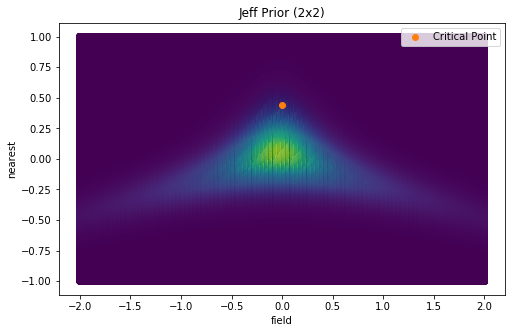

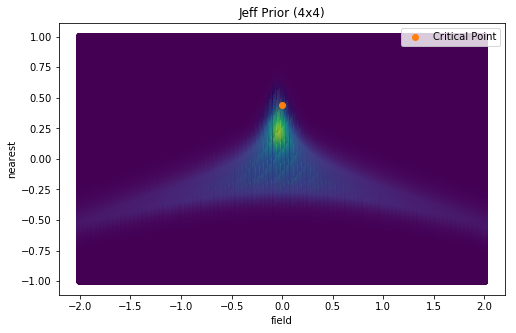

In [102]:
plt.figure(figsize=(8,5))
plt.title('Jeff Prior (2x2)')
plt.scatter(points[:,1],points[:,2],c=priors2)
plt.scatter(points[0:1,1],points[0:1,2],c='C1',label='Critical Point')
plt.xlabel('field')
plt.ylabel('nearest')
plt.legend()
plt.show()

plt.figure(figsize=(8,5))
plt.title('Jeff Prior (4x4)')
plt.scatter(points[:,1],points[:,2],c=priors4)
plt.scatter(points[0:1,1],points[0:1,2],c='C1',label='Critical Point')
plt.xlabel('field')
plt.ylabel('nearest')
plt.legend()
plt.show()

In [70]:
cutoff2 = max(priors2)/10
cutoff4 = max(priors4)/10

points2_cut = []
priors2_cut = []
for i in range(len(priors2)):
    if points[i][-1] == 0:
        if priors2[i] > cutoff2:
            points2_cut.append(points[i])
            priors2_cut.append(priors2[i])
        
points4_cut = []
priors4_cut = []
for i in range(len(priors4)):
    if points[i][-1] == 0:
        if priors4[i] > cutoff4:
            points4_cut.append(points[i])
            priors4_cut.append(priors4[i])
        

In [71]:
points2_cut = np.array(points2_cut)
priors2_cut = np.array(priors2_cut)
points4_cut = np.array(points4_cut)
priors4_cut = np.array(priors4_cut)

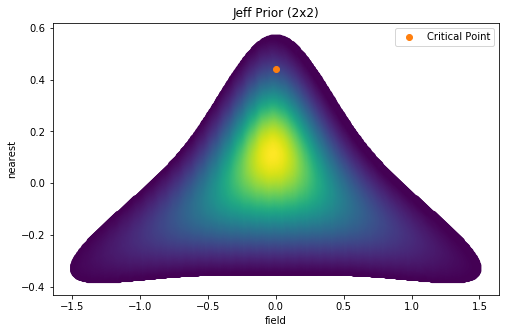

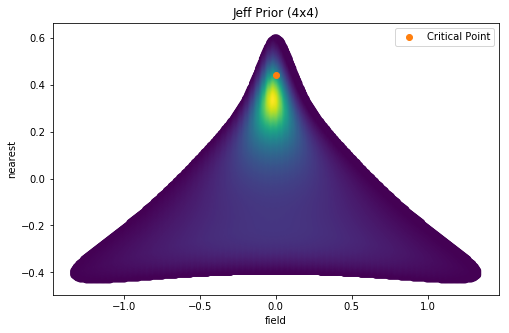

In [109]:
plt.figure(figsize=(8,5))
plt.title('Jeff Prior (2x2)')
plt.scatter(points2_cut[:,1],points2_cut[:,2],c=priors2_cut)
plt.scatter(points2_cut[0:1,1],points2_cut[0:1,2],c='C1',label='Critical Point')
plt.xlabel('field')
plt.ylabel('nearest')
plt.legend()
plt.show()

plt.figure(figsize=(8,5))
plt.title('Jeff Prior (4x4)')
plt.scatter(points4_cut[:,1],points4_cut[:,2],c=priors4_cut)
plt.scatter(points4_cut[0:1,1],points4_cut[0:1,2],c='C1',label='Critical Point')
plt.xlabel('field')
plt.ylabel('nearest')
plt.legend()
plt.show()

In [72]:
12000/len(points2_cut)

0.2678810608090008

In [73]:
draw2 = np.concatenate([[0],np.random.choice([i for i in range(len(priors2_cut))],12000,p=np.array(priors2_cut)/sum(priors2_cut))])
draw4 = np.concatenate([[0],np.random.choice([i for i in range(len(priors4_cut))],12000,p=np.array(priors4_cut)/sum(priors4_cut))])

In [74]:
plotPoints2 = np.array(points2_cut)[draw2]
plotPoints4 = np.array(points4_cut)[draw4]

Max Field:  1.472
Min Field:  -1.488

Max Nearest:  0.556
Min Nearest:  -0.372

Max Next Nearest:  0.0
Min Next Nearest:  0.0


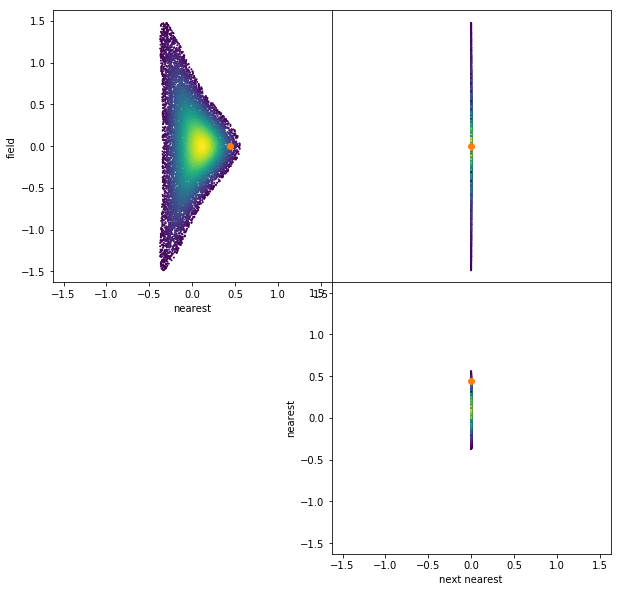

In [107]:
fmax = max(plotPoints2[:,1])
fmin = min(plotPoints2[:,1])
j1max = max(plotPoints2[:,2])
j1min = min(plotPoints2[:,2])
j2max = max(plotPoints2[:,3])
j2min = min(plotPoints2[:,3])
print('Max Field: ',fmax)
print('Min Field: ',fmin)
print()
print('Max Nearest: ',j1max)
print('Min Nearest: ',j1min)
print()
print('Max Next Nearest: ',j2max)
print('Min Next Nearest: ',j2min)

plotRange = 1.1*max([fmax-fmin,j1max-j1min,j2max-j2min])/2

fig, axes = plt.subplots(2,2,figsize=(10,10))

axes[0,0].scatter(np.array(plotPoints2)[:,2],np.array(plotPoints2)[:,1],s=1,c=priors2_cut[draw2])
axes[0,0].scatter(np.array(plotPoints2)[0:1,2],np.array(plotPoints2)[0:1,1],c='C1')
axes[0,0].set_ylabel('field')
axes[0,0].set_xlabel('nearest')

axes[0,1].scatter(np.array(plotPoints2)[:,3],np.array(plotPoints2)[:,1],s=1,c=priors2_cut[draw2])
axes[0,1].scatter(np.array(plotPoints2)[0:1,3],np.array(plotPoints2)[0:1,1],c='C1')
axes[0,1].set_yticks([])
axes[0,1].set_xticks([])

axes[1,1].scatter(np.array(plotPoints2)[:,3],np.array(plotPoints2)[:,2],s=1,c=priors2_cut[draw2])
axes[1,1].scatter(np.array(plotPoints2)[0:1,3],np.array(plotPoints2)[0:1,2],c='C1')
axes[1,1].set_ylabel('nearest')
axes[1,1].set_xlabel('next nearest')

axes[1,0].axis('off')

for i in [0,1]:
    for j in [0,1]:
        axes[i,j].set_xlim([-plotRange,plotRange])
        axes[i,j].set_ylim([-plotRange,plotRange])

plt.subplots_adjust(wspace=0, hspace=0)

plt.show()

Max Field:  1.328
Min Field:  -1.312

Max Nearest:  0.6
Min Nearest:  -0.432

Max Next Nearest:  0.0
Min Next Nearest:  0.0


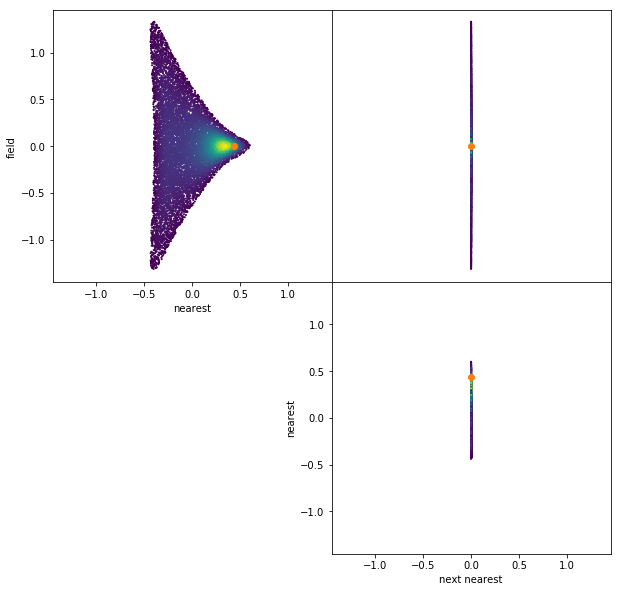

In [106]:
fmax = max(plotPoints4[:,1])
fmin = min(plotPoints4[:,1])
j1max = max(plotPoints4[:,2])
j1min = min(plotPoints4[:,2])
j2max = max(plotPoints4[:,3])
j2min = min(plotPoints4[:,3])
print('Max Field: ',fmax)
print('Min Field: ',fmin)
print()
print('Max Nearest: ',j1max)
print('Min Nearest: ',j1min)
print()
print('Max Next Nearest: ',j2max)
print('Min Next Nearest: ',j2min)

plotRange = 1.1*max([fmax-fmin,j1max-j1min,j2max-j2min])/2

fig, axes = plt.subplots(2,2,figsize=(10,10))

axes[0,0].scatter(np.array(plotPoints4)[:,2],np.array(plotPoints4)[:,1],s=1,c=priors4_cut[draw4])
axes[0,0].scatter(np.array(plotPoints4)[0:1,2],np.array(plotPoints4)[0:1,1],c='C1')
axes[0,0].set_ylabel('field')
axes[0,0].set_xlabel('nearest')

axes[0,1].scatter(np.array(plotPoints4)[:,3],np.array(plotPoints4)[:,1],s=1,c=priors4_cut[draw4])
axes[0,1].scatter(np.array(plotPoints4)[0:1,3],np.array(plotPoints4)[0:1,1],c='C1')
axes[0,1].set_yticks([])
axes[0,1].set_xticks([])

axes[1,1].scatter(np.array(plotPoints4)[:,3],np.array(plotPoints4)[:,2],s=1,c=priors4_cut[draw4])
axes[1,1].scatter(np.array(plotPoints4)[0:1,3],np.array(plotPoints4)[0:1,2],c='C1')
axes[1,1].set_ylabel('nearest')
axes[1,1].set_xlabel('next nearest')

axes[1,0].axis('off')

for i in [0,1]:
    for j in [0,1]:
        axes[i,j].set_xlim([-plotRange,plotRange])
        axes[i,j].set_ylim([-plotRange,plotRange])

plt.subplots_adjust(wspace=0, hspace=0)

plt.show()

In [77]:
data2 = Parallel(n_jobs=14)(delayed(makeDataDict)(T,M,j1,j2,n2,nn2,nnn2) for (T,M,j1,j2) in plotPoints4)
saveThing(data2,'Data/data2.pckl')

In [11]:
data2 = openThing('Data/data2.pckl')

In [78]:
DDT2 = DDT(data2)
saveThing(DDT2,'Data/DDT2x2.pckl')

In [7]:
DDT2 = openThing('Data/DDT2x2.pckl')

In [79]:
proj2_logs,W2_logs = projections(covMat(np.log(DDT2)),eigs=8)
proj2,W2 = projections(covMat(DDT2),eigs=8)
proj2_4Rep,W2_4Rep = projections(covMat(DDT2**4/4),eigs=8)

In [22]:
N = 128**2/4

In [23]:
N

4096.0

In [24]:
proj2_ManyRep,W2_ManyRep = projections(covMat(DDT2**(N)/(N)),eigs=8)

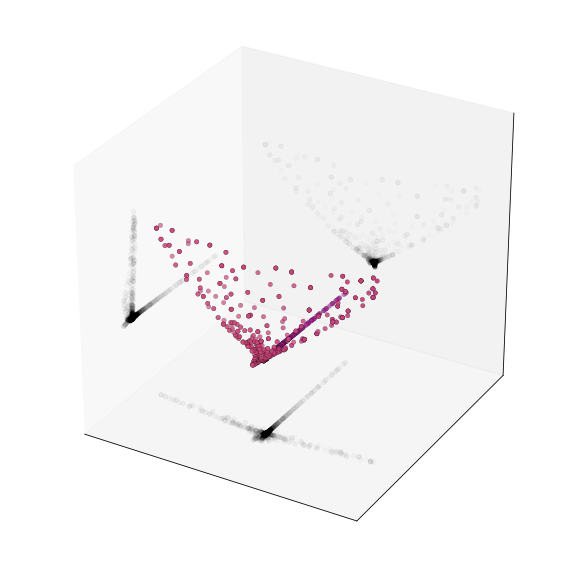

In [37]:
py = -proj2_ManyRep[:,2]
px = proj2_ManyRep[:,1]
pz = proj2_ManyRep[:,0]
plot3D(px,py,pz,[p['field'] for p in data2],cmap='plasma',shadow=True)

2x2 Ising, Many Replicas


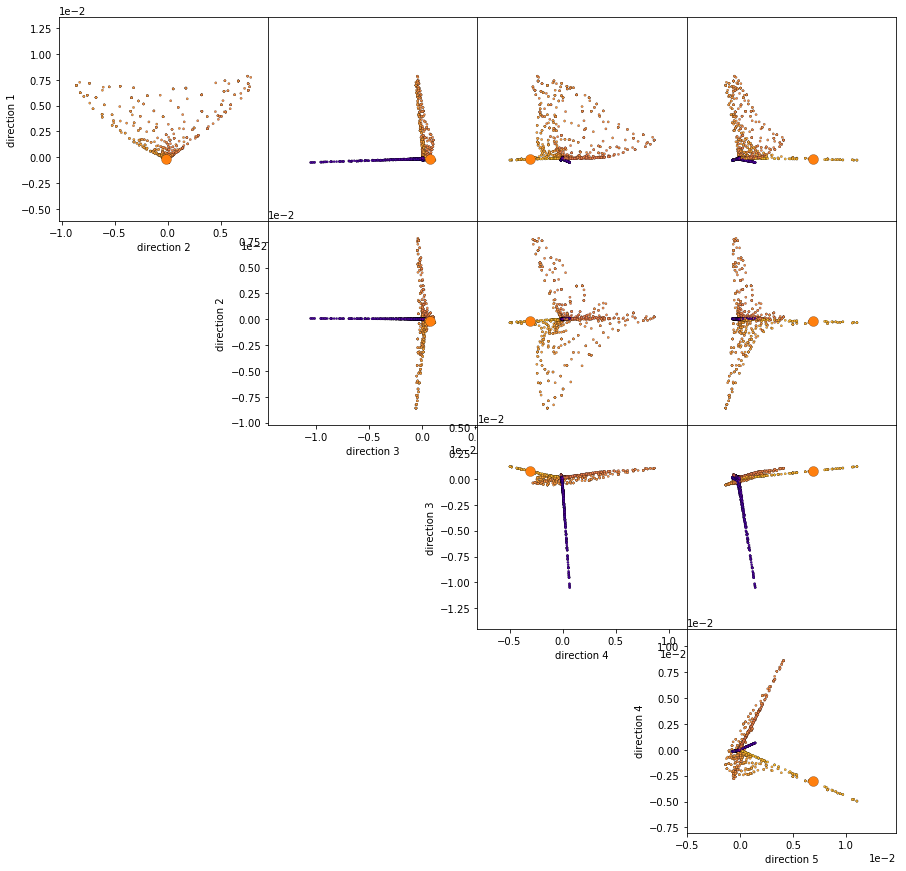

In [27]:
print('2x2 Ising, Many Replicas')
trianglePlot(proj2_ManyRep,[p['nearest'] for p in data2],cmap='plasma',dim=4,emphPoints=[0])

In [81]:
saveThing(proj2,'Data/proj2.pckl')
saveThing(W2,'Data/W2.pckl')

saveThing(proj2_logs,'Data/proj2_logs.pckl')
saveThing(W2_logs,'Data/W2_logs.pckl')

saveThing(proj2_4Rep,'Data/proj2_4Rep.pckl')
saveThing(W2_4Rep,'Data/W2_4Rep.pckl')

In [31]:
saveThing(proj2_ManyRep,'Data/proj2_ManyRep.pckl')
saveThing(W2_ManyRep,'Data/W2_ManyRep.pckl')

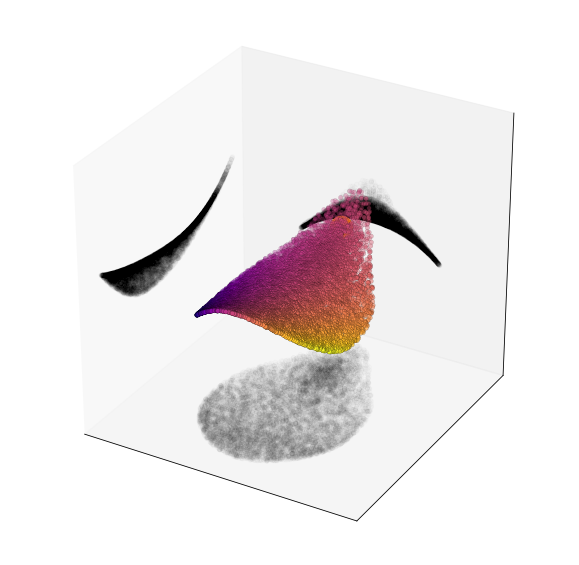

In [102]:
lengths = np.array([max(row) - min(row) for row in proj2_logs.T])
sorting = [lengths.argsort()[-i] for i in range(1,len(lengths)+1)]
proj2_logSorted = proj2_logs.T
proj2_logSorted = proj2_logSorted[sorting]
proj2_logSorted = proj2_logSorted.T

W2_logSorted = W2_logs[sorting]

py = -proj2_logs[:,0]
px = proj2_logs[:,1]
pz = -proj2_logs[:,2]
plot3D(px,py,pz,[p['field'] for p in data2],cmap='plasma',shadow=True,emphPoints=[0])

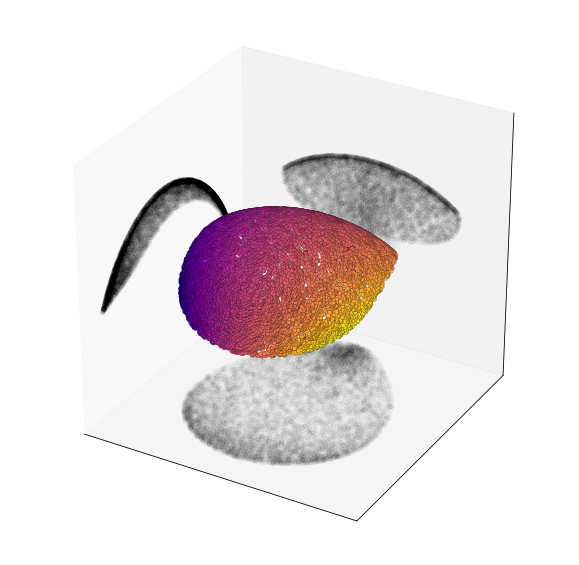

In [84]:
lengths = np.array([max(row) - min(row) for row in proj2.T])
sorting = [lengths.argsort()[-i] for i in range(1,len(lengths)+1)]
proj2Sorted = proj2.T
proj2Sorted = proj2Sorted[sorting]
proj2Sorted = proj2Sorted.T

W2Sorted = W2[sorting]

py = -proj2[:,0]
px = proj2[:,1]
pz = proj2[:,2]
plot3D(px,py,pz,[p['field'] for p in data2],cmap='plasma',shadow=True)

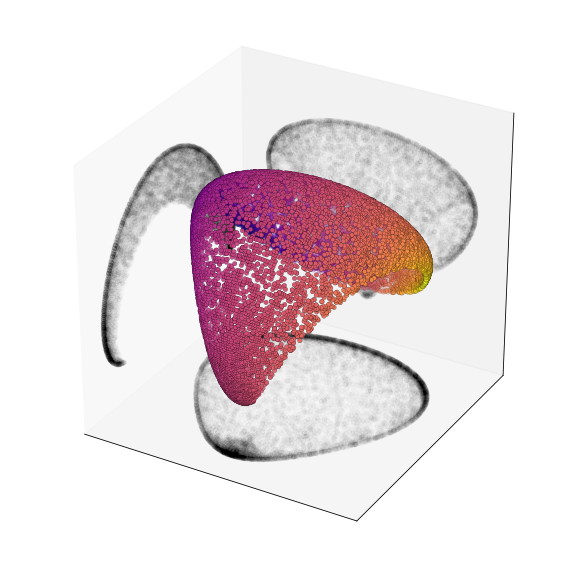

In [85]:
lengths = np.array([max(row) - min(row) for row in proj2_4Rep.T])
sorting = [lengths.argsort()[-i] for i in range(1,len(lengths)+1)]
proj2_4RepSorted = proj2_4Rep.T
proj2_4RepSorted = proj2_4RepSorted[sorting]
proj2_4RepSorted = proj2_4RepSorted.T

W2_4RepSorted = W2_4Rep[sorting]

py = -proj2_4Rep[:,0]
px = proj2_4Rep[:,1]
pz = proj2_4Rep[:,2]
plot3D(px,py,pz,[p['field'] for p in data2],cmap='plasma',shadow=True)

2x2 Ising, Hypersphere Embedding


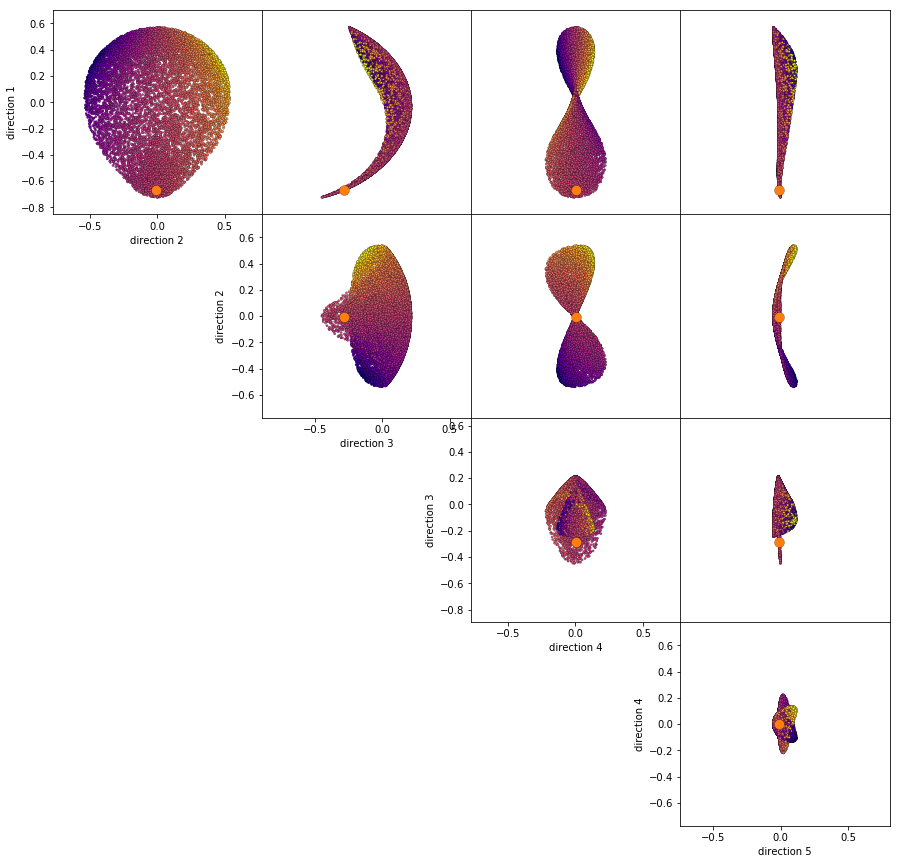


2x2 Ising, Intensive Embedding


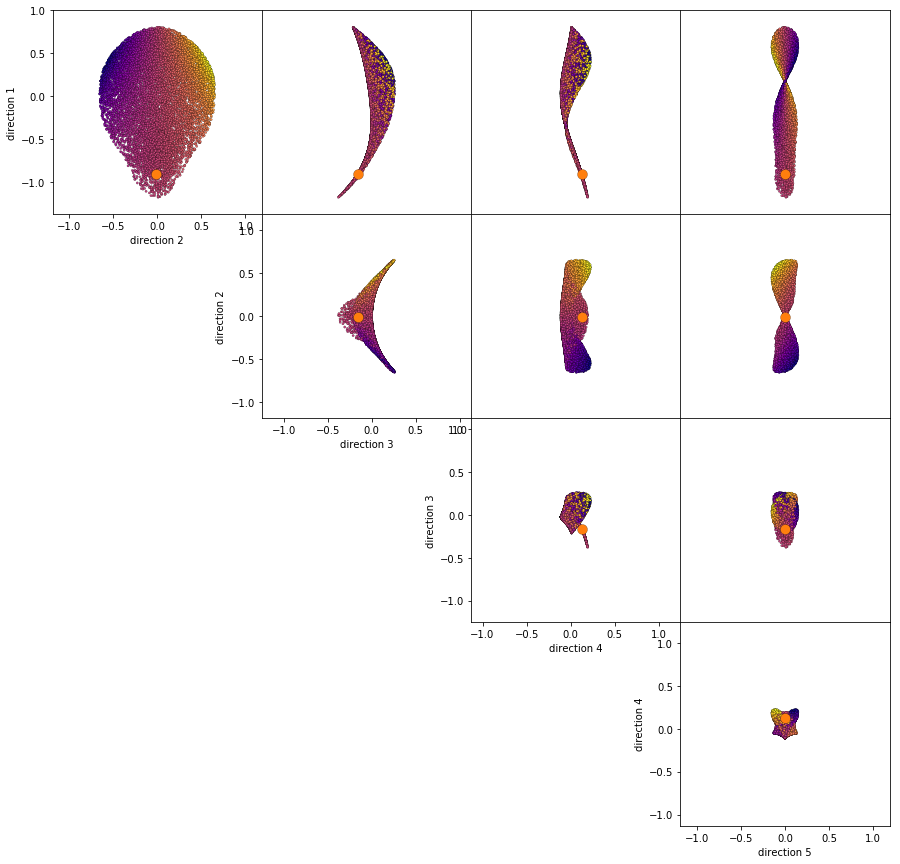


2x2 Ising, 4 Replicas, Intensive Embedding


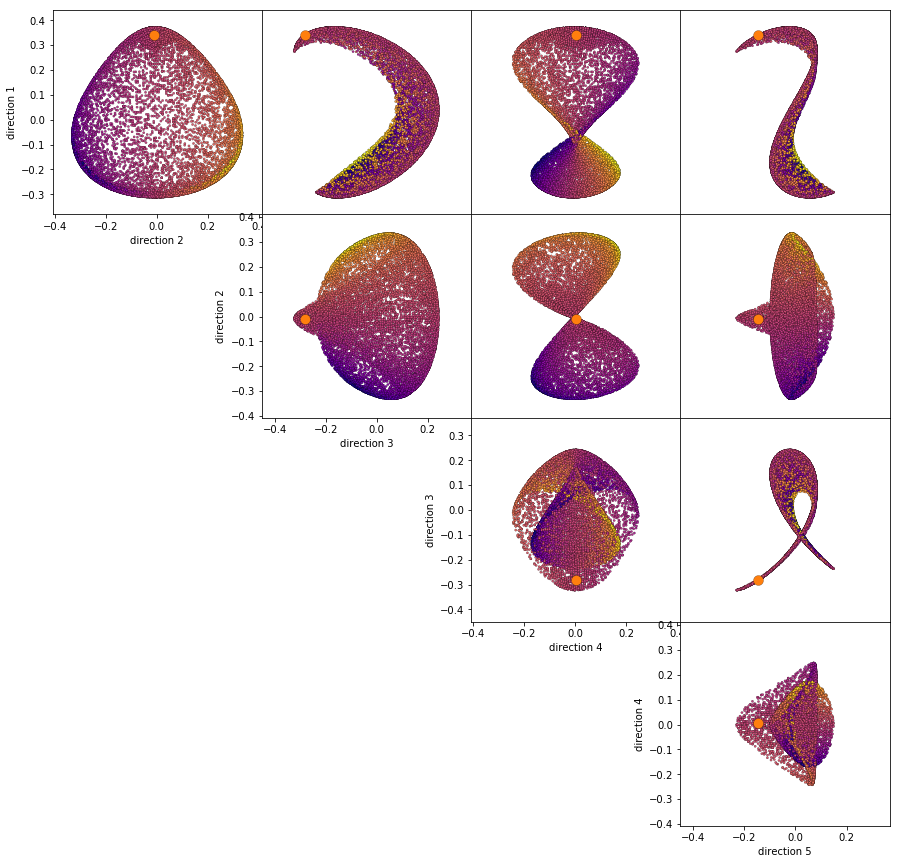

In [86]:
print('2x2 Ising, Hypersphere Embedding')
trianglePlot(proj2Sorted,[p['field'] for p in data2],cmap='plasma',dim=4,emphPoints=[0])
print('')
print('2x2 Ising, Intensive Embedding')
trianglePlot(proj2_logSorted,[p['field'] for p in data2],cmap='plasma',dim=4,emphPoints=[0])
print('')
print('2x2 Ising, 4 Replicas, Intensive Embedding')
trianglePlot(proj2_4RepSorted,[p['field'] for p in data2],cmap='plasma',dim=4,emphPoints=[0])

In [ ]:
projEigs = []
repRange = np.linspace(0,1,11)
for n in repRange:
    if n > 0:
        DDTn = DDT2**n/n
        projEigs.extend([projections(covMat(DDT2**n/n),eigs=10)])
    else:
        projEigs.extend([projections(covMat(np.log(DDT2)),eigs=10)])
projEigs = np.array(projEigs).T
proj = np.array([row for row in projEigs[0]])
eig = np.array([row for row in projEigs[1]])

In [ ]:
plt.figure(figsize=(8,5))
for idx in range(10):
    y = np.sqrt(abs(eig[:,idx]))
    plt.plot(repRange,y,label='eig '+str(idx))
plt.ylabel(r'$\sqrt{|\lambda|}$',fontsize=14)
plt.xlabel('number of replicas',fontsize=14)
plt.legend()
#plt.yscale('log')
#plt.ylim([1,50])
plt.title('Eigenvalues vs. Number of Repicas',fontsize=20)
plt.show()

plt.figure(figsize=(8,5))
for idx in range(10):
    #y = [2*max(abs(proj[i,:,idx])) for i in range(proj.shape[0])]
    y = [max(proj[i,:,idx]) - min(proj[i,:,idx]) for i in range(proj.shape[0])]
    plt.plot(repRange,y,label='component '+str(idx))
    
#plt.yscale('log')
plt.legend()
plt.xlabel('number of replicas',fontsize=14)
plt.ylabel('manifold length',fontsize=14)
#plt.yscale('log')
#plt.ylim([0.5,5])
plt.title('Manifold Length vs. Number of Replicas',fontsize=20)
plt.show()

4x4 Ising

In [89]:
data4 = Parallel(n_jobs=14)(delayed(makeDataDict)(T,M,j1,j2,n4,nn4,nnn4) for (T,M,j1,j2) in plotPoints4)
saveThing(data4,'Data/data4.pckl')

In [90]:
DDT4 = DDT(data4)
saveThing(DDT4,'Data/DDT4x4.pckl')

In [91]:
proj4_logs,W4_logs = projections(covMat(np.log(DDT4)))
proj4,W4 = projections(covMat(DDT4))

In [92]:
saveThing(proj4_logs,'Data/proj4_logs.pckl')
saveThing(proj4,'Data/proj4.pckl')
saveThing(W4,'Data/W4.pckl')

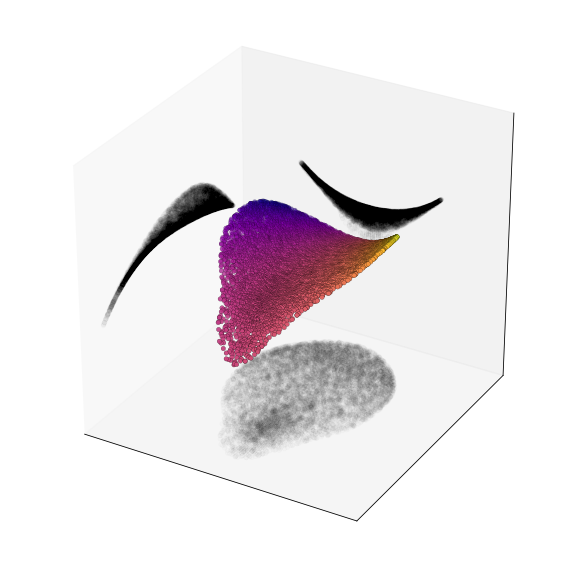

In [93]:
lengths = np.array([max(row)-min(row) for row in proj4_logs.T])
sorting = [lengths.argsort()[-i] for i in range(1,len(lengths)+1)]
proj4_logSorted = proj4_logs.T
proj4_logSorted = proj4_logSorted[sorting]
proj4_logSorted = proj4_logSorted.T

W4_logSorted = W4_logs[sorting]

py = proj2_logSorted[:,0]
px = proj2_logSorted[:,1]
pz = proj2_logSorted[:,2]
plot3D(px,py,pz,[p['field'] for p in data2],cmap='plasma',shadow=True)

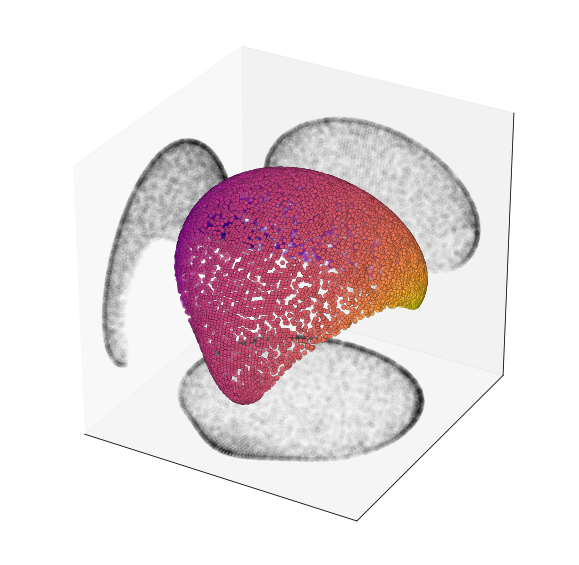

In [94]:
lengths = np.array([max(row)-min(row) for row in proj4.T])
sorting = [lengths.argsort()[-i] for i in range(1,len(lengths)+1)]
proj4Sorted = proj4.T
proj4Sorted = proj4Sorted[sorting]
proj4Sorted = proj4Sorted.T

W4Sorted = W4[sorting]

py = -proj4[:,0]
px = proj4[:,1]
pz = proj4[:,2]
plot3D(px,py,pz,[p['field'] for p in data2],cmap='plasma',shadow=True)

4x4 Ising, Hypersphere Embedding


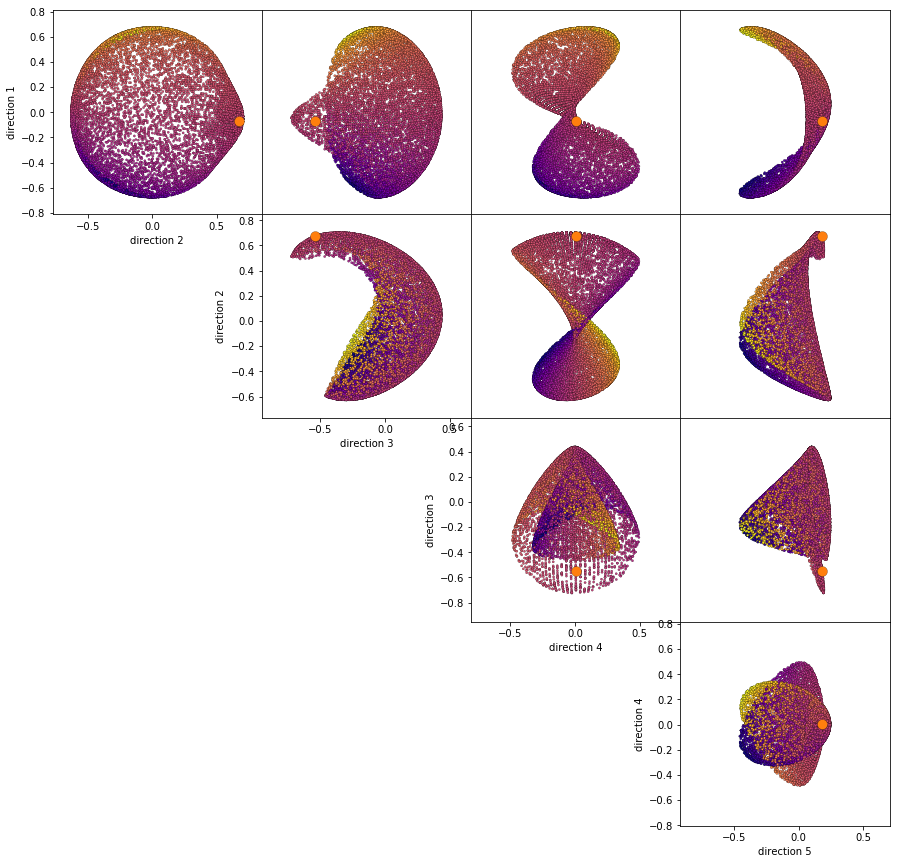


4x4 Ising, Intensive Embedding


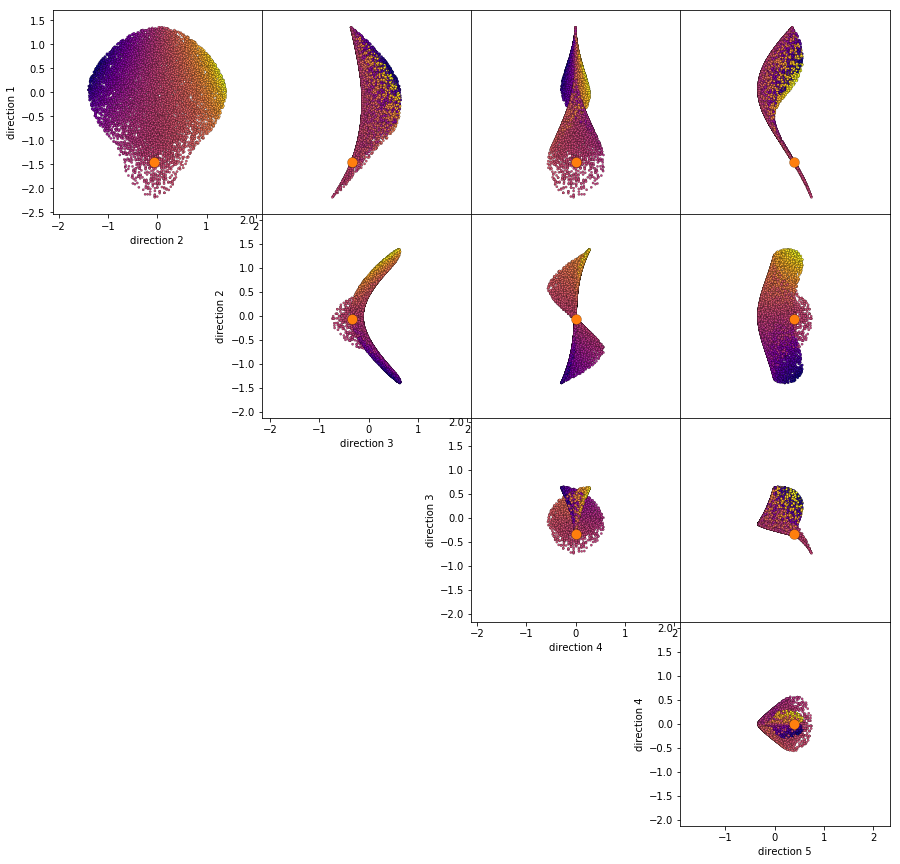

In [95]:
print('4x4 Ising, Hypersphere Embedding')
trianglePlot(proj4Sorted,[p['field'] for p in data4],cmap='plasma',dim=4,emphPoints=[0])
print('')
print('4x4 Ising, Intensive Embedding')
trianglePlot(proj4_logSorted,[p['field'] for p in data4],cmap='plasma',dim=4,emphPoints=[0])

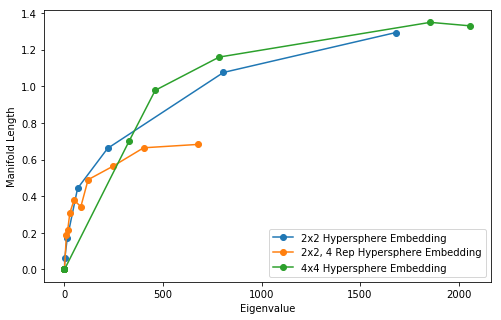

In [96]:
plt.figure(figsize=(8,5))
plt.plot(W2,[max(row) - min(row) for row in proj2.T],marker='o',label='2x2 Hypersphere Embedding')
plt.plot(W2_4Rep,[max(row) - min(row) for row in proj2_4Rep.T],marker='o',label='2x2, 4 Rep Hypersphere Embedding')
plt.plot(W4,[max(row) - min(row) for row in proj4.T],marker='o',label='4x4 Hypersphere Embedding')
plt.legend()
plt.xlabel('Eigenvalue')
plt.ylabel('Manifold Length')
plt.show()

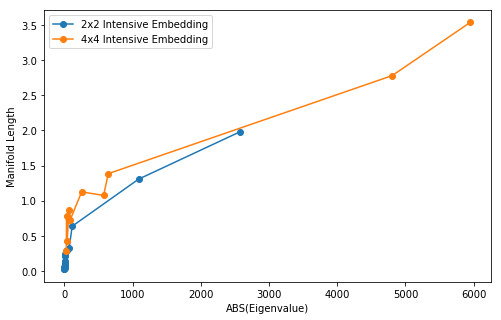

In [97]:
plt.figure(figsize=(8,5))
plt.plot(abs(W2_logs),[max(row) - min(row) for row in proj2_logs.T],marker='o',label='2x2 Intensive Embedding')
plt.plot(abs(W4_logs),[max(row) - min(row) for row in proj4_logs.T],marker='o',label='4x4 Intensive Embedding')
plt.legend()
plt.xlabel('ABS(Eigenvalue)')
plt.ylabel('Manifold Length')
plt.show()

In [99]:
data2[0]

{'H': array([-3.52549435, -0.        , -0.        , -0.        , -0.        ,
        -0.        ,  3.52549435, -0.        , -0.        ,  3.52549435,
        -0.        , -0.        , -0.        , -0.        , -0.        ,
        -3.52549435]),
 'field': 0.0,
 'freeEnergy': 4.3820266346738812,
 'nearest': 0.44068679350977147,
 'nextnearest': 0.0,
 'sqrtProbVector': array([ 0.65163796,  0.1118034 ,  0.1118034 ,  0.1118034 ,  0.1118034 ,
         0.1118034 ,  0.01918243,  0.1118034 ,  0.1118034 ,  0.01918243,
         0.1118034 ,  0.1118034 ,  0.1118034 ,  0.1118034 ,  0.1118034 ,
         0.65163796]),
 'temp': 1.0}